# Detecting Human Activities Through Smartphone Sensor - Training

## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
from tqdm import tqdm
import seaborn as sns
import filecmp
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import warnings
from sklearn.neighbors import KNeighborsClassifier
import pydot
from IPython.display import Image
from mlxtend import plotting
from six import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

## Global Variables

In [2]:
PBAR_FORMAT='{desc:12}{percentage:3.0f}%|{bar:27}[ {n:4d}/{total:4d}, {elapsed}<{remaining}{postfix} ]'

ACTIVITY_CODES_MAP = {'A': 'walking',
                          'B': 'jogging',
                          'C': 'stairs',
                          'D': 'sitting',
                          'E': 'standing',
                          'F': 'typing',
                          'G': 'brushing teeth',
                          'H': 'eating soup',
                          'I': 'eating chips',
                          'J': 'eating pasta',
                          'K': 'drinking from cup',
                          'L': 'eating sandwich',
                          'M': 'kicking soccer ball',
                          'O': 'playing catch tennis ball',
                          'P': 'dribbling basket ball',
                          'Q': 'writing',
                          'R': 'clapping',
                          'S': 'folding clothes'}

ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "typing", "brushing teeth",
                  "eating soup", "eating chips", "eating pasta", "drinking from cup", "eating sandwich",
                  "kicking soccer ball", "playing catch tennis ball", "dribbling basket ball",
                  "writing", "clapping", "folding clothes"]

# csv file column names
COL_NAMES =  ['id' , 'activity_code' , 'timestamp', 'x', 'y', 'z']
# training verbose
VERBOSE = 1
# rnadom state for split
RANDOM_STATE=12345

## Extracted Features

In [3]:
EXTRACTED_FEATURES = ['ACTIVITY',
                        'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
                        'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9',
                        'Z0', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9',
                        'XAVG', 'YAVG', 'ZAVG',
                        'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV',
                        'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV',
                        'XVAR', 'YVAR', 'ZVAR',
                        'XMFCC0', 'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4',
                        'XMFCC5', 'XMFCC6', 'XMFCC7',
                        'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11', 'XMFCC12',
                        'YMFCC0', 'YMFCC1', 'YMFCC2', 'YMFCC3', 'YMFCC4',
                        'YMFCC5', 'YMFCC6', 'YMFCC7',
                        'YMFCC8', 'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12',
                        'ZMFCC0', 'ZMFCC1', 'ZMFCC2', 'ZMFCC3', 'ZMFCC4',
                        'ZMFCC5', 'ZMFCC6', 'ZMFCC7',
                        'ZMFCC8', 'ZMFCC9', 'ZMFCC10', 'ZMFCC11', 'ZMFCC12',
                        'XYCOS', 'XZCOS', 'YZCOS',
                        'XYCOR', 'XZCOR', 'YZCOR',
                        'RESULTANT',
                        'PARTICIPANT'] # Categirical: 1600 -1650

len(EXTRACTED_FEATURES)


90

## Dataset

In [4]:
def WISDM_Dataset(DATA_DIR):
    all_files = glob.glob(DATA_DIR + "/*.txt")

    list_dfs = []
    for filename in all_files:
        df = pd.read_csv(filename, names = EXTRACTED_FEATURES, index_col=None, header=0)
        list_dfs.append(df)

    all_data = pd.concat(list_dfs, axis=0, ignore_index=True, sort=False)

    return all_data


## Training on Watch - Accelerometer

### Hyper parameters

In [5]:
NUM_SPLITS=5
TRAIN_SIZE=0.8
TEST_SIZE=1-TRAIN_SIZE

param_grid = {'n_neighbors': [3, 5, 10, 20], 'leaf_size': [10, 20, 30, 40]}
DATA_DIR="../dataset/processed/watch/accel"

### Initialize Dataset

In [6]:
all_watch_accel = WISDM_Dataset(DATA_DIR)

# The approach in this analysis will be to see all the participants as a single, unified group.
# The aim of this analysis is not to examine differences between participants.
all_watch_accel.drop('PARTICIPANT', axis = 1, inplace = True)

y = all_watch_accel.ACTIVITY
X = all_watch_accel.drop('ACTIVITY', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = TRAIN_SIZE,
                                                    test_size = TEST_SIZE,
                                                    shuffle = True,
                                                    stratify = y)

# Temporarily re-unite the train lables to train dataset for further preprocessing steps.
X_train.insert(0, 'Y', y_train)

# separating y_train
y_train = X_train['Y']
X_train.drop(['Y'], axis = 1, inplace = True)

# rescaling is applied to the features that their absolute values exceed the range of ~1
rescalin_features=['XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']
scaling_transformer = MaxAbsScaler().fit(X_train[rescalin_features])
X_train[rescalin_features] = scaling_transformer.transform(X_train[rescalin_features])

X_test = X_test.copy()
X_test[rescalin_features] = scaling_transformer.transform(X_test[rescalin_features])

# resetting the indices
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [7]:
X_train.columns

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'Y0', 'Y1',
       'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1', 'Z2', 'Z3',
       'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV',
       'YABSOLDEV', 'ZABSOLDEV', 'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR',
       'YVAR', 'ZVAR', 'XMFCC0', 'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4',
       'XMFCC5', 'XMFCC6', 'XMFCC7', 'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11',
       'XMFCC12', 'YMFCC0', 'YMFCC1', 'YMFCC2', 'YMFCC3', 'YMFCC4', 'YMFCC5',
       'YMFCC6', 'YMFCC7', 'YMFCC8', 'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12',
       'ZMFCC0', 'ZMFCC1', 'ZMFCC2', 'ZMFCC3', 'ZMFCC4', 'ZMFCC5', 'ZMFCC6',
       'ZMFCC7', 'ZMFCC8', 'ZMFCC9', 'ZMFCC10', 'ZMFCC11', 'ZMFCC12', 'XYCOS',
       'XZCOS', 'YZCOS', 'XYCOR', 'XZCOR', 'YZCOR', 'RESULTANT'],
      dtype='object')

### Training

In [8]:
my_cv = StratifiedShuffleSplit(n_splits=NUM_SPLITS,
                               train_size=TRAIN_SIZE,
                               test_size=TEST_SIZE)

knn_classifier = KNeighborsClassifier()
knn_model_gs = GridSearchCV(estimator=knn_classifier,
                        param_grid=param_grid,
                        cv=my_cv,
                        scoring='accuracy',
                        verbose = 0,
                        return_train_score = True)
knn_model_gs.fit(X_train, y_train)
knn_best_classifier = knn_model_gs.best_estimator_
print(knn_model_gs.best_params_)
print(knn_model_gs.cv_results_)
print(knn_best_classifier.get_params())

{'leaf_size': 10, 'n_neighbors': 5}
{'mean_fit_time': array([0.01401577, 0.01369004, 0.0136898 , 0.01405325, 0.01363468,
       0.01369362, 0.01356258, 0.01360288, 0.01368256, 0.01355815,
       0.01351438, 0.01362591, 0.01362147, 0.01360421, 0.01354947,
       0.01357265]), 'std_fit_time': array([8.19815819e-04, 8.34124905e-05, 1.25491854e-04, 5.85683702e-04,
       1.01191541e-04, 1.34007650e-04, 4.04364095e-05, 1.37017031e-04,
       1.96728900e-04, 5.99428121e-05, 4.27714160e-05, 6.86422616e-05,
       1.45092121e-04, 1.83354794e-04, 7.52225693e-05, 9.14312590e-05]), 'mean_score_time': array([0.11030107, 0.09561491, 0.09767203, 0.10463653, 0.09232426,
       0.09285102, 0.09686003, 0.1013679 , 0.09225044, 0.09285884,
       0.09723945, 0.10286222, 0.10003095, 0.09618616, 0.09699607,
       0.1028336 ]), 'std_score_time': array([0.03874257, 0.0042399 , 0.0020097 , 0.00365222, 0.00094478,
       0.00095581, 0.00105322, 0.00154618, 0.00091211, 0.00107106,
       0.00097814, 0.00257242

### Evaluation

#### Train Accuracy

In [9]:
scores = cross_val_score(knn_best_classifier, X_train, y_train, cv=my_cv, scoring='accuracy')
print(list(scores))

knn_best_classifier.score(X_train, y_train)
y_train_pred = knn_best_classifier.predict(X_train)

print("######################################################################################")
print("train accuracy:", 100 * accuracy_score(y_true=y_train, y_pred=y_train_pred))
print("######################################################################################")

[0.6236902050113895, 0.6250569476082004, 0.6154897494305239, 0.6100227790432802, 0.6059225512528473]


######################################################################################
train accuracy: 73.62186788154898
######################################################################################


#### Confusion Matrix

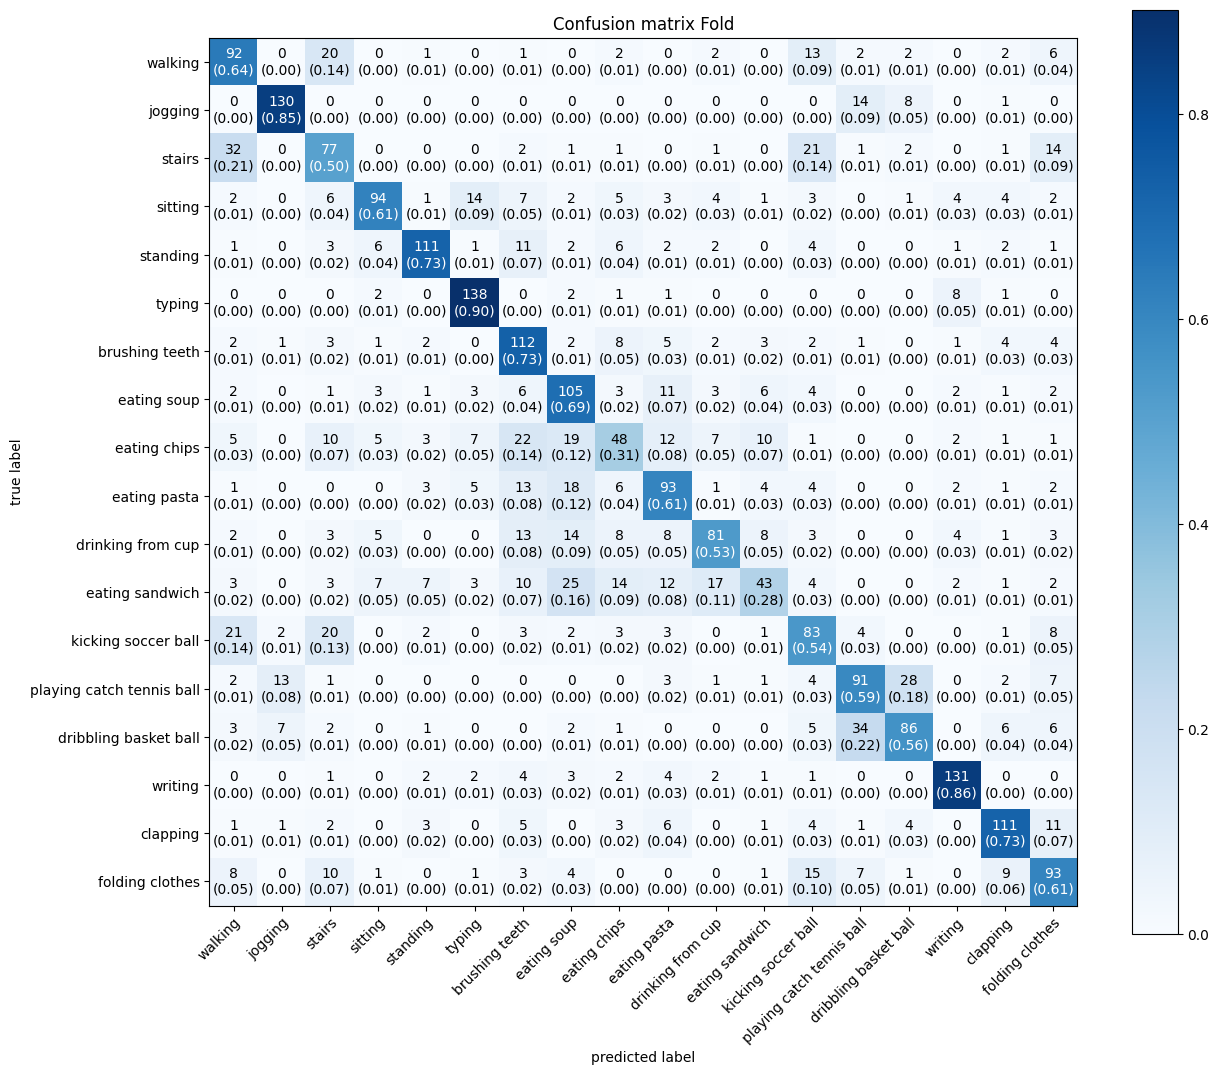

In [10]:
y_test_pred = knn_best_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
plotting.plot_confusion_matrix(conf_mat = conf_matrix,
                               class_names = ACTIVITY_NAMES,
                               show_normed = True,
                               figsize = (14, 12),
                               colorbar = True)
plt.title("Confusion matrix Fold")
plt.show()

#### Accuracy Per Activity

In [11]:
cm_act = pd.DataFrame(conf_matrix,
                      index=knn_best_classifier.classes_,
                      columns=knn_best_classifier.classes_)

cm_act.columns = ACTIVITY_CODES_MAP.values()
cm_act.index = ACTIVITY_CODES_MAP.values()
accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())
print(accuracy_per_activity)

                                  0
walking                    0.643357
jogging                    0.849673
stairs                     0.503268
sitting                    0.614379
standing                   0.725490
typing                     0.901961
brushing teeth             0.732026
eating soup                0.686275
eating chips               0.313725
eating pasta               0.607843
drinking from cup          0.529412
eating sandwich            0.281046
kicking soccer ball        0.542484
playing catch tennis ball  0.594771
dribbling basket ball      0.562092
writing                    0.856209
clapping                   0.725490
folding clothes            0.607843


/tmp/ipykernel_2399371/1352430059.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())


#### Classification Report

In [12]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred))
print("######################################################################################")

              precision    recall  f1-score   support

           A       0.52      0.64      0.57       143
           B       0.84      0.85      0.85       153
           C       0.48      0.50      0.49       153
           D       0.76      0.61      0.68       153
           E       0.81      0.73      0.77       153
           F       0.79      0.90      0.84       153
           G       0.53      0.73      0.61       153
           H       0.52      0.69      0.59       153
           I       0.43      0.31      0.36       153
           J       0.57      0.61      0.59       153
           K       0.66      0.53      0.59       153
           L       0.54      0.28      0.37       153
           M       0.49      0.54      0.51       153
           O       0.59      0.59      0.59       153
           P       0.65      0.56      0.60       153
           Q       0.83      0.86      0.85       153
           R       0.74      0.73      0.74       153
           S       0.57    

#### Test Accuracy

In [13]:
print("test accuracy", 100 * accuracy_score(y_true=y_test, y_pred=y_test_pred))

test accuracy 62.64577259475219


## Training on Watch - Gyroscope

### Hyper parameters

In [14]:
NUM_SPLITS=5
TRAIN_SIZE=0.8
TEST_SIZE=1-TRAIN_SIZE

param_grid = {'n_neighbors': [3, 5, 10, 20], 'leaf_size': [10, 20, 30, 40]}
DATA_DIR="../dataset/processed/watch/gyro"

### Initialize Dataset

In [15]:
all_watch_gyro = WISDM_Dataset(DATA_DIR)

# The approach in this analysis will be to see all the participants as a single, unified group.
# The aim of this analysis is not to examine differences between participants.
all_watch_gyro.drop('PARTICIPANT', axis = 1, inplace = True)

y = all_watch_gyro.ACTIVITY
X = all_watch_gyro.drop('ACTIVITY', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = TRAIN_SIZE,
                                                    test_size = TEST_SIZE,
                                                    shuffle = True,
                                                    stratify = y)

# Temporarily re-unite the train lables to train dataset for further preprocessing steps.
X_train.insert(0, 'Y', y_train)

# separating y_train
y_train = X_train['Y']
X_train.drop(['Y'], axis = 1, inplace = True)

# rescaling is applied to the features that their absolute values exceed the range of ~1
rescalin_features=['XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']
scaling_transformer = MaxAbsScaler().fit(X_train[rescalin_features])
X_train[rescalin_features] = scaling_transformer.transform(X_train[rescalin_features])

X_test = X_test.copy()
X_test[rescalin_features] = scaling_transformer.transform(X_test[rescalin_features])

# resetting the indices
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [16]:
X_train.columns

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'Y0', 'Y1',
       'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1', 'Z2', 'Z3',
       'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV',
       'YABSOLDEV', 'ZABSOLDEV', 'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR',
       'YVAR', 'ZVAR', 'XMFCC0', 'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4',
       'XMFCC5', 'XMFCC6', 'XMFCC7', 'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11',
       'XMFCC12', 'YMFCC0', 'YMFCC1', 'YMFCC2', 'YMFCC3', 'YMFCC4', 'YMFCC5',
       'YMFCC6', 'YMFCC7', 'YMFCC8', 'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12',
       'ZMFCC0', 'ZMFCC1', 'ZMFCC2', 'ZMFCC3', 'ZMFCC4', 'ZMFCC5', 'ZMFCC6',
       'ZMFCC7', 'ZMFCC8', 'ZMFCC9', 'ZMFCC10', 'ZMFCC11', 'ZMFCC12', 'XYCOS',
       'XZCOS', 'YZCOS', 'XYCOR', 'XZCOR', 'YZCOR', 'RESULTANT'],
      dtype='object')

### Training

In [17]:
my_cv = StratifiedShuffleSplit(n_splits=NUM_SPLITS,
                               train_size=TRAIN_SIZE,
                               test_size=TEST_SIZE)

knn_classifier = KNeighborsClassifier()
knn_model_gs = GridSearchCV(estimator=knn_classifier,
                        param_grid=param_grid,
                        cv=my_cv,
                        scoring='accuracy',
                        verbose = 0,
                        return_train_score = True)
knn_model_gs.fit(X_train, y_train)
knn_best_classifier = knn_model_gs.best_estimator_
print(knn_model_gs.best_params_)
print(knn_model_gs.cv_results_)
print(knn_best_classifier.get_params())

{'leaf_size': 10, 'n_neighbors': 5}
{'mean_fit_time': array([0.01381564, 0.01358371, 0.01354251, 0.01346707, 0.01339445,
       0.01347814, 0.01364932, 0.01344409, 0.01349444, 0.01354628,
       0.01359382, 0.01341572, 0.01342745, 0.01352563, 0.01343365,
       0.01357579]), 'std_fit_time': array([5.76753989e-04, 1.71223214e-04, 8.83707525e-05, 4.06870928e-05,
       1.65519622e-04, 1.72362723e-04, 2.52875094e-04, 6.01440059e-05,
       9.57587558e-05, 1.28566599e-04, 3.80907676e-04, 4.83112997e-05,
       4.78385319e-05, 1.40710242e-04, 6.86773646e-05, 1.88230706e-04]), 'mean_score_time': array([0.09196234, 0.09387002, 0.09630785, 0.10246201, 0.09346533,
       0.09399552, 0.0999331 , 0.10162339, 0.0915134 , 0.09561539,
       0.10089531, 0.10120792, 0.09191523, 0.09642553, 0.09547825,
       0.10140438]), 'std_score_time': array([0.0006547 , 0.00185174, 0.00128618, 0.00335712, 0.00221668,
       0.0012072 , 0.00532425, 0.00057902, 0.0007135 , 0.0039288 ,
       0.00598898, 0.00102044

### Evaluation

#### Train Accuracy

In [18]:
scores = cross_val_score(knn_best_classifier, X_train, y_train, cv=my_cv, scoring='accuracy')
print(list(scores))

knn_best_classifier.score(X_train, y_train)
y_train_pred = knn_best_classifier.predict(X_train)

print("######################################################################################")
print("train accuracy:", 100 * accuracy_score(y_true=y_train, y_pred=y_train_pred))
print("######################################################################################")

[0.5394077448747152, 0.5357630979498861, 0.5416856492027334, 0.5394077448747152, 0.5416856492027334]


######################################################################################
train accuracy: 68.92027334851937
######################################################################################


#### Confusion Matrix

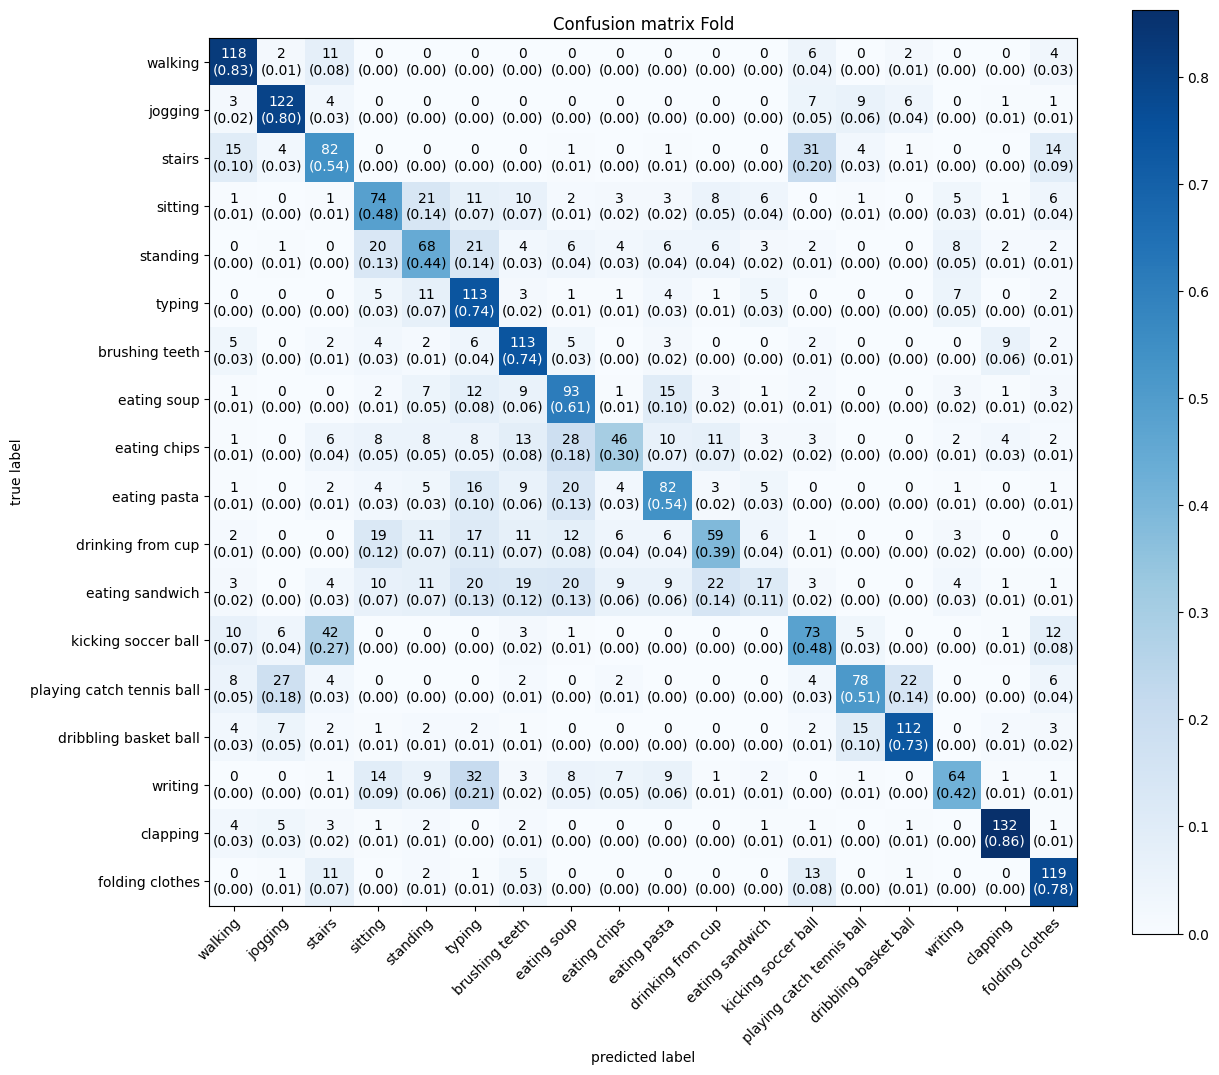

In [19]:
y_test_pred = knn_best_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
plotting.plot_confusion_matrix(conf_mat = conf_matrix,
                               class_names = ACTIVITY_NAMES,
                               show_normed = True,
                               figsize = (14, 12),
                               colorbar = True)
plt.title("Confusion matrix Fold")
plt.show()

#### Accuracy Per Activity

In [20]:
cm_act = pd.DataFrame(conf_matrix,
                      index=knn_best_classifier.classes_,
                      columns=knn_best_classifier.classes_)

cm_act.columns = ACTIVITY_CODES_MAP.values()
cm_act.index = ACTIVITY_CODES_MAP.values()
accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())
print(accuracy_per_activity)

                                  0
walking                    0.825175
jogging                    0.797386
stairs                     0.535948
sitting                    0.483660
standing                   0.444444
typing                     0.738562
brushing teeth             0.738562
eating soup                0.607843
eating chips               0.300654
eating pasta               0.535948
drinking from cup          0.385621
eating sandwich            0.111111
kicking soccer ball        0.477124
playing catch tennis ball  0.509804
dribbling basket ball      0.732026
writing                    0.418301
clapping                   0.862745
folding clothes            0.777778


/tmp/ipykernel_2399371/1352430059.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())


#### Classification Report

In [21]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred))
print("######################################################################################")

              precision    recall  f1-score   support

           A       0.67      0.83      0.74       143
           B       0.70      0.80      0.74       153
           C       0.47      0.54      0.50       153
           D       0.46      0.48      0.47       153
           E       0.43      0.44      0.44       153
           F       0.44      0.74      0.55       153
           G       0.55      0.74      0.63       153
           H       0.47      0.61      0.53       153
           I       0.55      0.30      0.39       153
           J       0.55      0.54      0.54       153
           K       0.52      0.39      0.44       153
           L       0.35      0.11      0.17       153
           M       0.49      0.48      0.48       153
           O       0.69      0.51      0.59       153
           P       0.77      0.73      0.75       153
           Q       0.66      0.42      0.51       153
           R       0.85      0.86      0.86       153
           S       0.66    

#### Test Accuracy

In [22]:
print("test accuracy", 100 * accuracy_score(y_true=y_test, y_pred=y_test_pred))

test accuracy 57.03352769679301
